# Solve the Taylor Goldstein eigenvalue problem
### Goal is to determine the complex valued internal wave phase velocity, $c$.
Classic Taylor Goldstein:
$$ (U-c)^2 (\phi'' -\alpha\phi) + [N^2 - (U-c)U'']\phi = 0 $$

Let's rewrite as a first order system. Introduce $\phi$,
$$  \phi'' +\left\{\alpha + \frac{N^2 - (U-c)U''}{(U-c)^2}\right\}\phi = 0 $$
then we have the system,
$$  \phi' = \psi $$
$$   \psi ' = \left[ \alpha^2   - \frac{N^2 -(U-c)U''}{(U-c)^2} \right]\phi$$



In [1]:
import numpy as np
from findiff import FinDiff
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from time import perf_counter

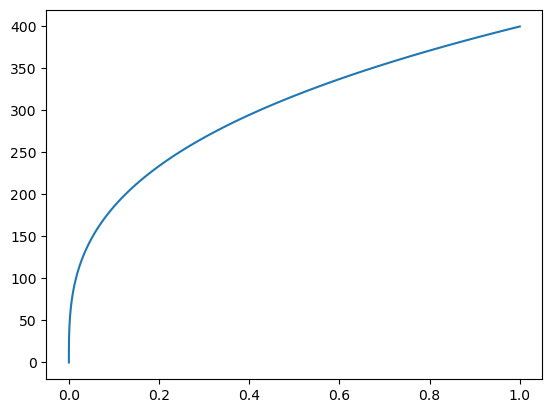

In [79]:
alpha = 1e-3
N = 1e-3
H = 400
z = np.linspace(0, H, 101)
dz = z[1] - z[0]
U = (z/H)**3

d_dz = FinDiff(0, dz, 1)
d2_dz2 = FinDiff(0, dz, 2)
d2U_dz2 = d2_dz2(U)
d2mat = np.array(d2_dz2.matrix(U.shape).toarray())

# Test the finite difference calculation of the velocity field
plt.plot(U,z)
# plt.plot(d2U_dz2*1e4,z)

In [80]:
# The same equations, formatted for different solvers.
# y[0] = phi  ~ uz
# y[1] = dphi/dz ~ ux

def tg(z,y,params):
    alpha,N,U,Upp,all_z,c = params
    ind = np.argmin(np.abs(all_z-z))
    coeff = alpha**2 - (N**2 - (U[ind]-c)*Upp[ind])/(U[ind]-c)**2
    return [y[1], coeff*y[0]]

def tg2(y,z,alpha,N,U,Upp,all_z,c):
    ind = np.argmin(np.abs(all_z-z))
    coeff = alpha**2 - (N**2 - (U[ind]-c) * Upp[ind])/(U[ind]-c)**2
    return [y[1], coeff*y[0]]


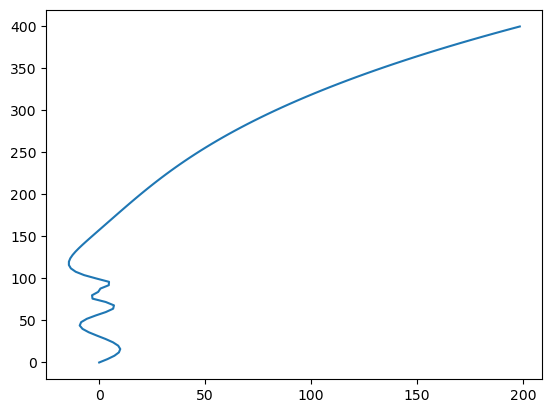

In [151]:
# Test a single solve using the ode interface
c_test = 0.01
sol = []
ic = [0,1]
sol.append(ic)
r = ode(tg)
r.set_initial_value(ic, z[0])
r.set_f_params( (alpha,N,U,d2U_dz2,z,c_test) )
# for zz in z:
for zz in z[1:]:
    sol.append(r.integrate(zz))
sol=np.array(sol)
plt.plot(sol[:,0],z)

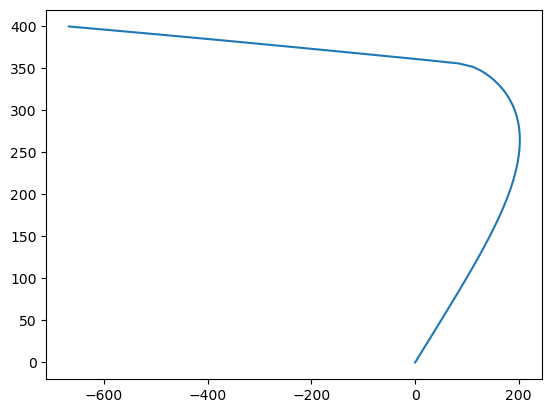

In [150]:
# Test a single solve using the odeint interface
c_test = 0.7
sol = odeint(tg2, [0,1], z,args=( (alpha,N,U,d2U_dz2,z,c_test) ))
plt.plot(sol[:,0],z)

## Use the complex_ode interface
We want to have a complex valued phase velocity to reflect the possiblity of waves growing or decaying in amplitude as they propagate.

Reference: https://stackoverflow.com/questions/34920813/python-complex-ode-pass-matrix-valued-parameters

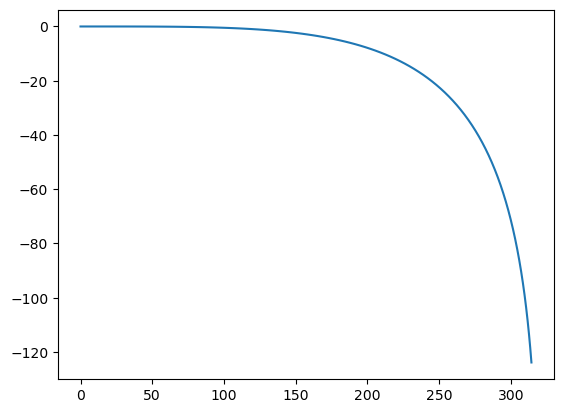

In [170]:
# Test a single solve using the ode interface
class myfuncs(object):
    def __init__(self, f, fargs=[]):
        self._f = f
        self.fargs=fargs

    def f(self, t, y):
        return self._f(t, y, self.fargs)

c_test = 1 - 1j
sol = []
ic = [0,1]
sol.append(ic)

args = [alpha,N,U,d2U_dz2,z,c_test]
case = myfuncs(tg, fargs=args )

solver = complex_ode(case.f)
solver.set_initial_value(ic, z[0])

# Per stack overflow, the following fails because of a bug
# r.set_f_params( args )

solver.integrate(z[1])

for zz in z[1:]:
    sol.append(solver.integrate(zz))
sol=np.array(sol)

plt.plot(np.real(sol[:,0]),np.imag(sol[:,0]))

## Shooting methods are great, but they don't generalize to complex ODEs...
...or at least if they do, I didn't immediately figure out how.

In [102]:
# Shooting method: try different c until ux(0)=0
def target(c_array):
    out = []
    ux0 = 1
    uz0 = 0
    initial_condition = [uz0,ux0]
    for c in c_array:
        sol = odeint(tg2, initial_condition, z,
                     args=( (alpha,N,U,d2U_dz2,z,c) ))
        out.append( sol[-1,0] )
    return out

/tmp/ipykernel_2002558/4118471511.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  coeff = alpha**2 - (N**2 - (U[ind]-c) * Upp[ind])/(U[ind]-c)**2
/tmp/ipykernel_2002558/4118471511.py:14: RuntimeWarning: invalid value encountered in scalar multiply
  return [y[1], coeff*y[0]]


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1184257523663D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3981652677926D+03   r2 =                  NaN


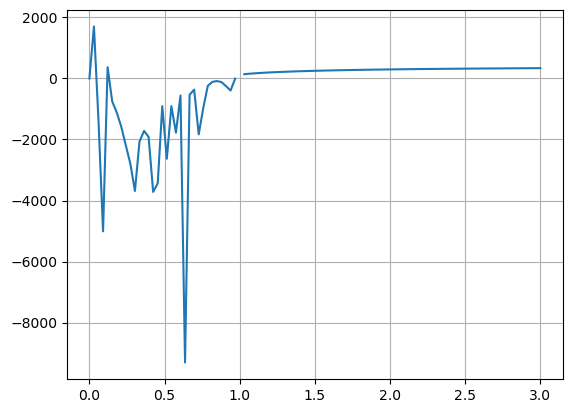

In [104]:
# x_test = np.logspace(-1,1,1000)
x_test = np.linspace(0,3,100)
plt.plot(x_test,target(x_test))
# plt.ylim([-1,1])
plt.grid()

In [105]:
def my_optimize(target,rng,xtol=1e-3,verbose=False):
    # Just return the greatest zero crossing in the interval
    max_fun_evals = 100
    x_test = np.linspace(rng[0],rng[1],max_fun_evals)
    vals = target(x_test)
    sign = np.sign(vals)
    test = (sign != sign[-1]) * np.arange(len(sign))
    winner = np.argmax(test)
    
    if np.mean(np.diff(x_test)) > xtol:
        if verbose: print('Recursing')
        new_rng = (x_test[winner-1],x_test[winner+1])
        output = my_optimize(target,new_rng,xtol=xtol)
        return output
    else:
        return x_test[winner]

In [106]:

t0 = perf_counter()
this_root = my_optimize(target, (0.9,3))
print(f'This root = {this_root}')
print(f'{perf_counter()-t0}')

This root = 0.9407101316192226
6.312523531727493


# Optimization in the complex plane
In the following, I search for roots of the complex-valued equation manually by zooming in on different parts of the phase plane.

In [222]:
# Test a single solve using the ode interface
class myfuncs(object):
    def __init__(self, f, fargs=[]):
        self._f = f
        self.fargs=fargs

    def f(self, t, y):
        return self._f(t, y, self.fargs)
    
def complex_plane(cr_list,ci_list):
    ic = [0,1]
    nr = len(cr_list)
    ni = len(ci_list)
    amplitude = np.zeros((nr,ni))

    for j,ci in enumerate(ci_list):
        for i,cr in enumerate(cr_list):
            c_test = cr + 1j*ci
            sol = []
            sol.append(ic)
            args = [alpha,N,U,d2U_dz2,z,c_test]
            case = myfuncs(tg, fargs=args )

            solver = complex_ode(case.f)
            solver.set_initial_value(ic, z[0])

            # Per stack overflow, the following fails because of a bug
            # r.set_f_params( args )

            solver.integrate(z[1])

            for zz in z[1:]:
                sol.append(solver.integrate(zz))
            sol=np.array(sol)

            amplitude[i,j] = np.abs(sol[-1,0])
    return amplitude

In [206]:
t0 = perf_counter()
cr_list = 10*np.linspace(-1,1,nr)
ci_list = 10*np.linspace(-1,1,ni)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

58.480921604670584


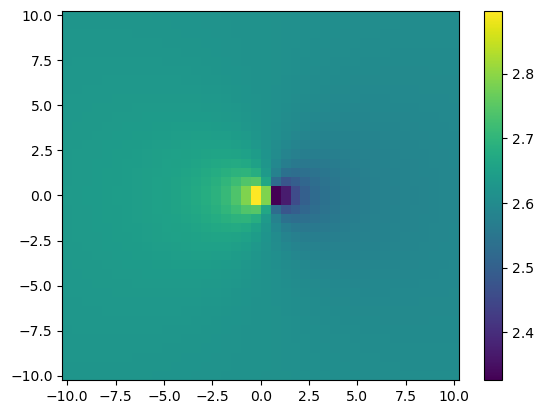

In [208]:
plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T))
plt.colorbar(c)
plt.show()

In [209]:
t0 = perf_counter()
cr_list = 5*np.linspace(-1,1,nr)
ci_list = 5*np.linspace(-1,1,ni)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

57.493264748714864


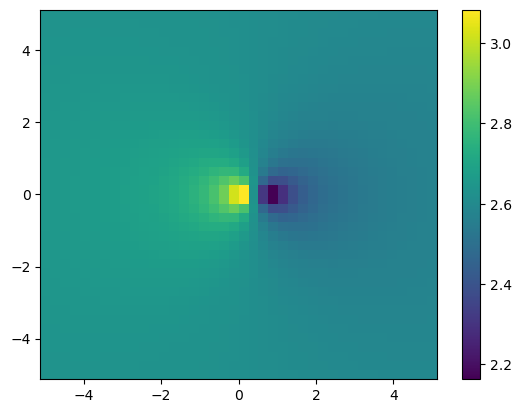

In [210]:
plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T))
plt.colorbar(c)
plt.show()

69.88345677219331


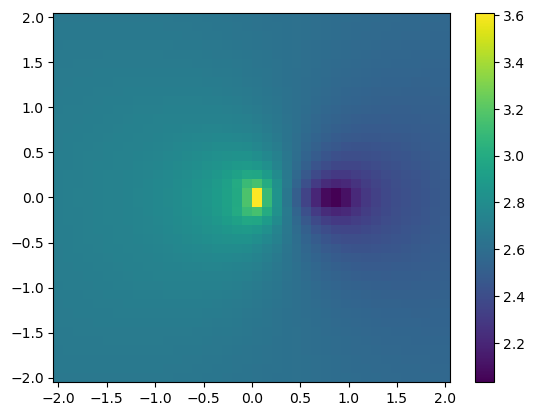

In [211]:
t0 = perf_counter()
cr_list = 2*np.linspace(-1,1,nr)
ci_list = 2*np.linspace(-1,1,ni)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T))
plt.colorbar(c)
plt.show()

72.43217257037759


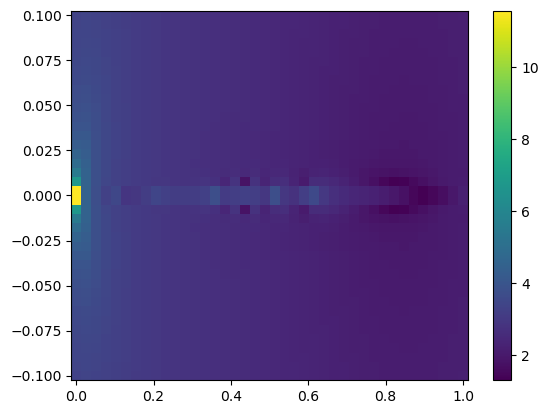

In [214]:
t0 = perf_counter()
cr_list = np.linspace(0,1,nr)
ci_list = 0.1*np.linspace(-1,1,ni)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T))
plt.colorbar(c)
plt.show()

626.0015380494297


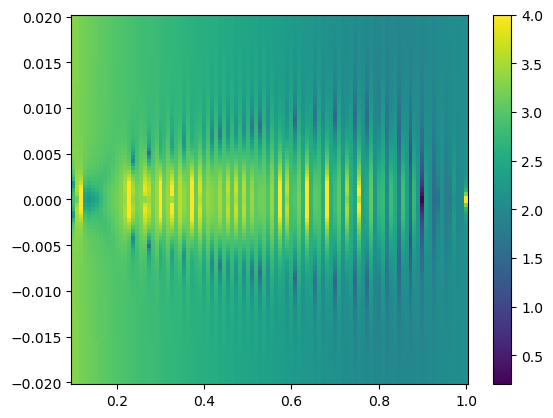

In [223]:
t0 = perf_counter()
cr_list = np.linspace(0.1,1,100)
ci_list = 0.02*np.linspace(-1,1,100)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T),vmax=4)
plt.colorbar(c)
plt.show()

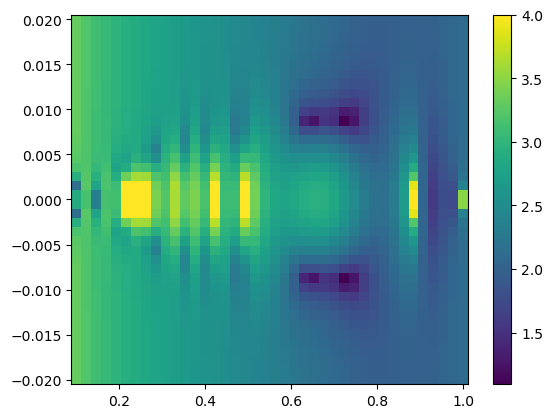

In [220]:
t0 = perf_counter()
cr_list = np.linspace(0.1,1,40)
ci_list = 0.02*np.linspace(-1,1,40)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T),vmax=4)
plt.colorbar(c)
plt.show()

117.45432792976499


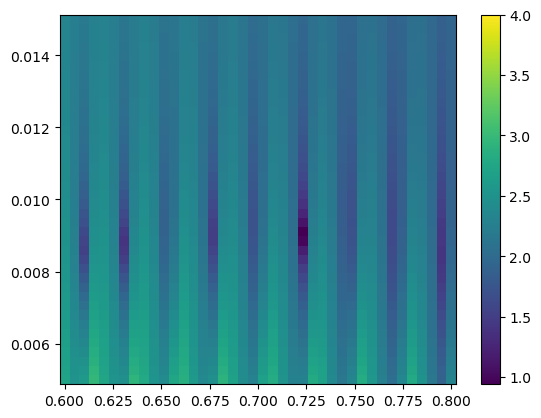

In [224]:
t0 = perf_counter()
cr_list = np.linspace(0.6,0.8,40)
ci_list = np.linspace(0.005,0.015,40)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T),vmax=4)
plt.colorbar(c)
plt.show()

129.51527207158506


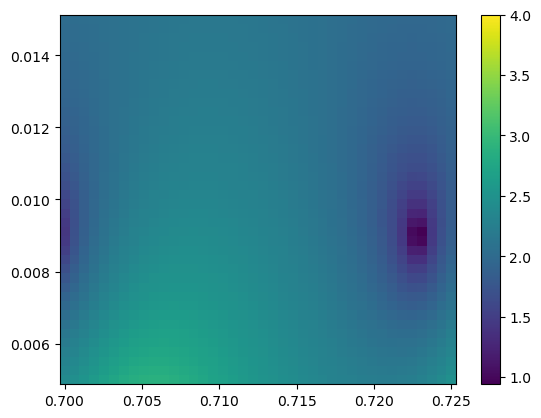

In [225]:
t0 = perf_counter()
cr_list = np.linspace(0.7,0.725,40)
ci_list = np.linspace(0.005,0.015,40)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T),vmax=4)
plt.colorbar(c)
plt.show()

148.14775547664613


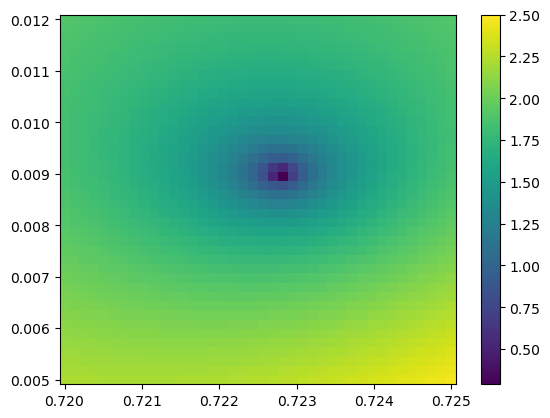

In [226]:
t0 = perf_counter()
cr_list = np.linspace(0.720,0.725,40)
ci_list = np.linspace(0.005,0.012,40)
A=complex_plane(cr_list,ci_list)
print(f'{perf_counter()-t0}')

plt.subplots()
c = plt.pcolormesh(cr_list,ci_list, np.log10(A.T),vmax=2.5)
plt.colorbar(c)
plt.show()